In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import *
from commando.utilities import predict_nn
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

In [300]:
np.random.seed(42)

# Export h5 (experimental)

In [4]:
# dataset_name = 'BrainChromatin'
# modality_names = ['RNA', 'ATAC']
# data1 = pd.read_csv("../data/brainchromatin/multiome_rna_counts.tsv", delimiter='\t').transpose()

# data2 = pd.read_csv("../data/brainchromatin/multiome_atac_gene_activities.tsv", delimiter='\t', nrows=35000).transpose()  # Only a subset
# data2 = data2.transpose()[data1.index].transpose()

# dataset = [data1, data2]
# features = [np.array(d.columns) for d in dataset]

In [5]:
# import h5py

# data = np.concatenate(dataset, axis=1).T
# shape = np.array(np.shape(data)).astype('int')
# data = data.flatten(order='F').astype('float')
# barcodes = np.array(['Unknown' for _ in range(shape[1])]).astype('|S')
# indices = np.array(shape[1] * [i for i in range(shape[0])]).astype('int')
# indptr = np.array([i*shape[0] for i in range(shape[1]+1)]).astype('int')

# _all_tag_keys = np.array(['genome']).astype('|S')
# # First dataset should be RNA, second ATAC
# feature_type = np.array(dataset[0].shape[1] * ['Gene Expression'] + dataset[1].shape[1] * ['Peaks']).astype('|S')
# genome = np.array(['Unknown' for _ in range(shape[0])]).astype('|S')
# # id = np.array(['Unknown' for _ in range(shape[0])]).astype('|S')
# id = np.array(list(features[0]) + list(features[1])).astype('|S')
# # name = np.array(['Unknown' for _ in range(shape[0])]).astype('|S')
# name = np.array(list(features[0]) + list(features[1])).astype('|S')

# with h5py.File('../../../babel/test.h5', 'w') as f: # '../babel_data/test.h5'
#     mat = f.create_group('matrix')
#     mat.create_dataset('barcodes', data=barcodes)
#     mat.create_dataset('data', data=data)
#     mat.create_dataset('indices', data=indices)
#     mat.create_dataset('indptr', data=indptr)
#     mat.create_dataset('shape', data=shape)

#     fea = mat.create_group('features')
#     fea.create_dataset('_all_tag_keys', data=_all_tag_keys)
#     fea.create_dataset('feature_type', data=feature_type)
#     fea.create_dataset('genome', data=genome)
#     fea.create_dataset('id', data=id)
#     fea.create_dataset('name', data=name)
    
# # try:
# #     f.close()
# # except:
# #     pass
# # f = h5py.File('../babel_data/test.h5', 'r')

# # for n in f['matrix']:
# #     print(n)
# #     print(f['matrix'][n])
# #     print()
    
# # f.close()

# # import scipy
# # scipy.sparse.csc_matrix((data, indices, indptr)).toarray().shape

# # # try:
# # #     samp.close()
# # # except:
# # #     pass
# # # samp = h5py.File('../data/babel/DM_rep4.h5', 'r')

# # # for n in samp['matrix']['features']:
# # #     print(n)
# # #     print(samp['matrix']['features'][n])
# # #     print()
# # # print(samp['matrix']['features']['_all_tag_keys'][()])
# # # print(samp['matrix']['features']['id'][()])
# # # print(samp['matrix']['barcodes'][()])
    
# # # samp.close()
# # import scanpy as sc
# sc.read_10x_h5('../../../babel/test.h5', gex_only=False)
# # sc.read_10x_h5('../data/babel/DM_rep4.h5', gex_only=False)

# Back to normal things

In [301]:
from sklearn.decomposition import PCA

dataset_name = 'BrainChromatin'
modality_names = ['RNA', 'ATAC']
data1 = pd.read_csv("../data/brainchromatin/multiome_rna_counts.tsv", delimiter='\t').transpose()
# PCA
# proc = PCA(n_components=32).fit_transform(data1)
# d1 = pd.DataFrame(proc)
# d1.index = data1.index
# data1 = d1

data2 = pd.read_csv("../data/brainchromatin/multiome_atac_gene_activities.tsv", delimiter='\t', nrows=35000).transpose()  # Only a subset
# PCA
# proc = PCA(n_components=32).fit_transform(data2)
# d2 = pd.DataFrame(proc)
# d2.index = data2.index
# data2 = d2
data2 = data2.transpose()[data1.index].transpose()

meta = pd.read_csv("../data/brainchromatin/multiome_cell_metadata.txt", delimiter='\t')
meta_names = pd.read_csv("../data/brainchromatin/multiome_cluster_names.txt", delimiter='\t')
meta_names = meta_names[meta_names['Assay'] == 'Multiome ATAC']
meta = pd.merge(meta, meta_names, left_on='ATAC_cluster', right_on='Cluster.ID', how='left')
meta.index = meta['Cell.ID']

type1 = type2 = np.array(meta.transpose()[data1.index].transpose()['Cluster.Name'])
fname1, fname2 = data1.columns, data2.columns
data1 = data1.to_numpy()
data2 = data2.to_numpy()

# Sampling
split = 1000 # data1.shape[0]
data_row_idx = np.random.choice(range(data1.shape[0]), split, replace=False)
data1, data2, type1, type2 = (x[data_row_idx] for x in (data1, data2, type1, type2))
# split_feat_1 = 2000 # data1.shape[1]
# data_col1_idx = np.random.choice(range(data1.shape[1]), split_feat_1, replace=False)
# data1, fname1 = data1[:, data_col1_idx], fname1[data_col1_idx]
# split_feat_2 = 2000 # data2.shape[1]
# data_col2_idx = np.random.choice(range(data2.shape[1]), split_feat_2, replace=False)
# data2, fname2 = data2[:, data_col2_idx], fname2[data_col2_idx]

# Labels
labels = [type1, type2]
features = [fname1, fname2]

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
data1 = preprocessing.MinMaxScaler().fit_transform(data1)
data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = [f'Feature {i}' for i in range(dataset[i].shape[1])]

In [302]:
# Group labels
group = ['GluN3', 'GluN4', 'IN1', 'GluN2', 'IN2', 'GluN6', 'GluN5', 'RG',
       'nIPC', 'GluN1', 'mGPC/OPC', 'IN3', 'IN4', 'SP', 'GluN7',
       'MG/EC/Peric.']
conv =  ['GluN', 'GluN', 'IN', 'GluN', 'IN', 'GluN', 'GluN', 'RG',
        'nIPC', 'GluN', 'mGPC/OPC', 'IN', 'IN', 'SP', 'GluN',
        'MG/EC/Peric.']
group_conv = {g:c for g, c in zip(group, conv)}
labels = [np.array([group_conv[l] for l in label]) for label in labels]

In [8]:
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

In [9]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 256
pca_dim = [256, 256]
dist_method = 'euclidean'

# ComManDo

In [10]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 2500,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': dist_method,
    'loss_weights': [1,1,1,1],
}
fromChar = [' ', '),', '(', ')', ',', '\'', '[', ']']
toChar = ['', '--', '', '', '-', '', '(', ')']
kwargs_str = str(sorted(kwargs.items()))[1:-1]
for f, t in zip(fromChar, toChar):
    kwargs_str = kwargs_str.replace(f, t)
hash_str = '---'.join([dataset_name, '-'.join([str(s) for s in dataset[0].shape]), '-'.join([str(s) for s in dataset[1].shape]), kwargs_str])

In [11]:
# Integration
cm = ComManDo(**kwargs)  # , match_result=cm.match_result, debug=True)
model_str = 'saved_models/cm---' + hash_str + '.h5'
try:
    # raise FileNotFoundError()
    cm.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
except FileNotFoundError:
    cm_data = cm.fit_transform(dataset=dataset)
    cm.save_model(model_str)
cm_data = cm.transform(dataset=dataset)

In [12]:
# Imputation
cm_im = ComManDo(**kwargs)
model_str = 'saved_models/cm_im---' + hash_str + '.h5'
try:
    # raise FileNotFoundError()
    cm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
except FileNotFoundError:
    cm_im.fit_transform(dataset=[data1[train_idx], data2[train_idx]])
    cm_im.save_model(model_str)
cm_imputed = [cm_im.modal_predict(dataset[i][test_idx], i) for i in range(1, -1, -1)]

# Comparison Methods

In [13]:
integrated_data = [cm_data]
integrated_names = ['JAMIE']
colors = ['blue']

In [14]:
# NLMA
nlma_data, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
integrated_data.append(nlma_data)
integrated_names.append('NLMA')
colors.append('red')

In [15]:
# # LMA
# lma_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
# integrated_data.append(lma_data)
# integrated_names.append('LMA')
# colors.append('orange')

In [16]:
# # CCA
# cca_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
# integrated_data.append(cca_data)
# integrated_names.append('CCA')
# colors.append('m')

In [17]:
# # MMD-MA
# from sklearn.metrics import pairwise_distances
# mmd_ma_data, _, _ = mmd_combine(pairwise_distances(dataset[0]), pairwise_distances(dataset[1]), method='mmd_ma', p=reduced_dim)
# integrated_data.append(mmd_ma_data)
# integrated_names.append('MMD-MA')
# colors.append('yellow')

In [18]:
# UnionCom
uc_data, _, _ = mmd_combine(*dataset, method='unioncom', output_dim=reduced_dim)
integrated_data.append(uc_data)
integrated_names.append('Unioncom')
colors.append('green')

In [58]:
# Imputation
if False:
    imputation_name = 'Babel'
else:
    imputation_name = 'Dual Autoencoder'
    nn_imputed = [predict_nn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i][test_idx]).float()) for i in range(1, -1, -1)]
imputed_data = [cm_imputed, nn_imputed][::-1]
imputed_names = ['JAMIE', imputation_name][::-1]

# Visualization

In [303]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

In [304]:
%%capture
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

algorithm_elements = [Line2D([0], [0], color=c, lw=5, label=n) for n, c in zip(integrated_names, colors)]
label_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], label=l, markersize=10) for i, l in enumerate(np.unique(labels))]

# https://stackoverflow.com/a/47749903
fig, ax = plt.subplots()
legend = ax.legend(handles=label_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('./output_figures/' + dataset_name + '-LabelLegend.png', bbox_inches=bbox, dpi=300)

fig, ax = plt.subplots()
legend = ax.legend(handles=algorithm_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('./output_figures/' + dataset_name + '-AlgorithmLegend.png', bbox_inches=bbox, dpi=300)

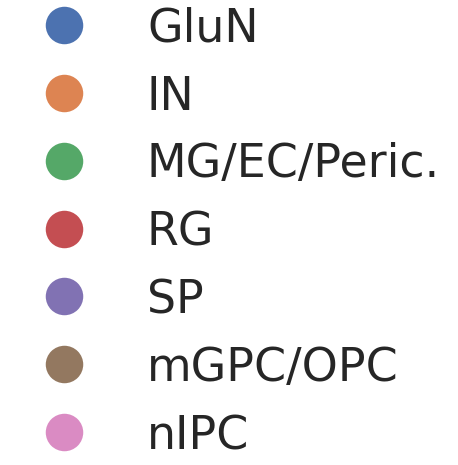

In [305]:
from IPython.display import Image
Image(filename='./output_figures/' + dataset_name + '-LabelLegend.png', width=100)

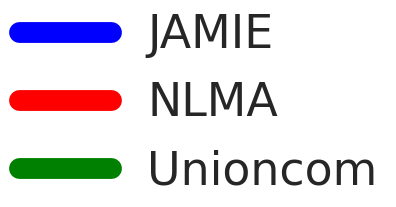

In [306]:
from IPython.display import Image
Image(filename='./output_figures/' + dataset_name + '-AlgorithmLegend.png', width=100)

In [24]:
fig = plt.figure(figsize=(10, 5))
plot_regular(dataset, labels, modality_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Data.png', dpi=300)

In [25]:
# fig = plt.figure(figsize=(10, 5))
# plot_integrated(cm_data, labels, ['JAMIE - ' + mn for mn in modality_names])
# plt.tight_layout()
# plt.savefig('./output_figures/' + dataset_name + '-JAMIE.png', dpi=300)

In [26]:
for d, n in zip(integrated_data, integrated_names):
    fig = plt.figure(figsize=(10, 5))
    plot_integrated(d, labels, [f'{n} - ' + mn for mn in modality_names], legend=False)
    plt.tight_layout()
    plt.savefig('./output_figures/' + dataset_name + f'-{n}.png', dpi=300)
    plt.show()

In [27]:
plt.figure(figsize=(5, 5))
plot_accuracy_graph(integrated_data, labels, integrated_names, colors=colors)
sns.despine()
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Acc.png', dpi=300)

In [28]:
plt.figure(figsize=(15, 5))
plot_silhouette([[d[0]] for d in integrated_data], [labels[0]], integrated_names, modality_names[:1], colors=colors)
sns.despine()
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sil.png', dpi=300)

In [59]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp1.png', dpi=300)

In [60]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp2.png', dpi=300)

An input array is constant; the correlation coefficient is not defined.


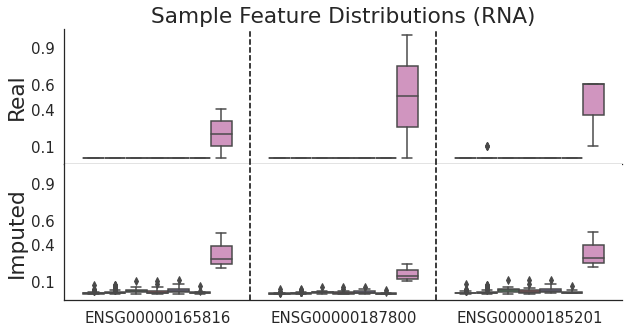

In [307]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.savefig('./output_figures/' + dataset_name + '-Dist1.png', dpi=300)

An input array is constant; the correlation coefficient is not defined.


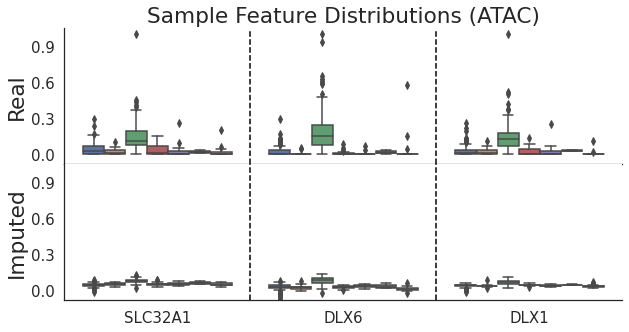

In [308]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.savefig('./output_figures/' + dataset_name + '-Dist2.png', dpi=300)

In [33]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim1.png', dpi=300)

In [34]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim2.png', dpi=300)

# Explanation

In [252]:
mod0, mod1 = 1, 0

In [295]:
from commando.utilities import sort_by_interest

order, interest = sort_by_interest([cm_imputed[mod1], dataset[mod1][test_idx]], limit=10)
order_str = ', '.join([str(n) for n in order[:10]])
order_names_str = ', '.join(features[mod1][order[:10]])
print(f'Top performing features:\n{order_names_str}\n{order_str}')
print()
interest_str = ', '.join([str(n) for n in interest[:10]])
interest_names_str = ', '.join(features[mod1][interest[:10]])
print(f'Top interesting features:\n{interest_names_str}\n{interest_str}')

An input array is constant; the correlation coefficient is not defined.


Top performing features:
ENSG00000165816, ENSG00000138119, ENSG00000185201, ENSG00000163191, ENSG00000170955, ENSG00000118777, ENSG00000116016, ENSG00000163453, ENSG00000088992, ENSG00000175899
17152, 16905, 17371, 1893, 17592, 7945, 3685, 7719, 20848, 19517

Top interesting features:
ENSG00000165816, ENSG00000138119, ENSG00000185201, ENSG00000163191, ENSG00000170955, ENSG00000118777, ENSG00000116016, ENSG00000163453, ENSG00000088992, ENSG00000175899
17152, 16905, 17371, 1893, 17592, 7945, 3685, 7719, 20848, 19517


In [296]:
from scipy import stats

# Omit one testing
in_data = dataset[mod0].copy()
target = interest[0]
out_data = dataset[mod1][:, target]
current_cm = cm_im

background = in_data.mean(0)
logits = cm.modal_predict(in_data, mod0)[:, target]
baseline = stats.pearsonr(logits, out_data)

performance = []
best_idx = -1
best_perf = -np.inf
best_str = ''
check_best = 10
testing_idx = np.random.choice(dataset[mod0].shape[1], int(1e3), replace=False)
# testing_idx = np.array(range(in_data.shape[1]))
for i, idx in enumerate(testing_idx):
    # CLI
    if (i+1) % check_best == 0 and len(performance) > 0:
        best_idx = np.argmax(performance)
        best_perf = performance[best_idx]
        best_str = features[mod0][testing_idx[best_idx]]
    prog_str = math.floor(50*(i+1)/len(testing_idx)) * '|'
    print(
        f'{i+1:>{len(str(len(testing_idx)))}}/{len(testing_idx)} [{prog_str:<50}] - '
        f'Current Best: {best_perf:.5f}, {best_str}'
        , end='\r')
    
    mod_data = in_data
    # Replace one
    # replace_idx = idx  # Replace one
    replace_idx = [i!=idx for i in range(mod_data.shape[1])]  # Keep one
    old_data = mod_data[:, replace_idx]
    mod_data[:, replace_idx] = background[replace_idx]
    
    # Predict
    logits = cm.modal_predict(mod_data, mod0)[:, target]
    
    # Repair
    mod_data[:, replace_idx] = old_data
    
    # Record
    corr = stats.pearsonr(logits, out_data)[0]
    # corr = -np.sum((logits - out_data)**2)
    if np.isnan(corr):
        corr = -np.inf
    performance.append(corr)
print('\nDone!')
performance = np.array(performance)

An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


An input array is nearly constant; the computed correlation coefficient may be inaccurate.


1000/1000 [||||||||||||||||||||||||||||||||||||||||||||||||||] - Current Best: 0.09794, ABCA4
Done!


In [297]:
sorted_idx = testing_idx[np.argsort(performance)[::-1]]
sorted_names = features[mod0][sorted_idx]
sorted_perf = np.sort(performance)[::-1]
target_name = features[mod1][target]

display = 20
print(f'Target {modality_names[mod1]} Feature: {target_name}')
print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={target_name}')
importance = features[mod0][sorted_idx][:display]
imp_str = ', '.join(importance)
print(f'Important {modality_names[mod0]} Features: {imp_str}')
for n, p in zip(importance, sorted_perf[:display]):
    print(f'{p:.5f}: https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

Target RNA Feature: ENSG00000165816
https://www.genecards.org/cgi-bin/carddisp.pl?gene=ENSG00000165816
Important ATAC Features: ABCA4, TMEM106A, EIF6, IL24, LRRC15, OR7G3, ENDOU, RNF113B, ACVRL1, FER1L6, GCM2, CDR2L, AL022238.4, C9orf16, AGTRAP, IGSF8, FCRL5, TMEM87A, MT1F, DAGLA
0.09794: https://www.genecards.org/cgi-bin/carddisp.pl?gene=ABCA4
0.07722: https://www.genecards.org/cgi-bin/carddisp.pl?gene=TMEM106A
0.07486: https://www.genecards.org/cgi-bin/carddisp.pl?gene=EIF6
0.06578: https://www.genecards.org/cgi-bin/carddisp.pl?gene=IL24
0.06571: https://www.genecards.org/cgi-bin/carddisp.pl?gene=LRRC15
0.06268: https://www.genecards.org/cgi-bin/carddisp.pl?gene=OR7G3
0.06140: https://www.genecards.org/cgi-bin/carddisp.pl?gene=ENDOU
0.05566: https://www.genecards.org/cgi-bin/carddisp.pl?gene=RNF113B
0.05332: https://www.genecards.org/cgi-bin/carddisp.pl?gene=ACVRL1
0.05159: https://www.genecards.org/cgi-bin/carddisp.pl?gene=FER1L6
0.05095: https://www.genecards.org/cgi-bin/carddisp.p

## SHAP

In [257]:
# RNA (Place) -> ATAC
# ENSG00000251562 (4) -> HYLS1
# ENSG00000251562 (4) -> HYLS1

# ATAC (Place) -> RNA
# ANKRD16 -> ENSG00000138119
# PWWP2B

In [258]:
import shap

# Subset for runtime
use_subsetting = True
subset_idx = np.random.choice(dataset[mod0].shape[1], 100, replace=False)
background = np.mean(dataset[mod0], axis=0).reshape((1, -1))
def take_subset(x, do=use_subsetting):
    if not do:
        return x
    if len(x.shape) == 1:
        return x[subset_idx]
    return x[:, subset_idx]
def reverse_subset(x, do=use_subsetting):
    if not do:
        return x
    new_vec = np.concatenate(x.shape[0] * [background], axis=0)
    new_vec[:, subset_idx] = x
    return new_vec

target_feature = interest[0]
current_cm = cm_im
model = lambda x: current_cm.modal_predict(reverse_subset(x), mod0)[:, target_feature]
data = dataset[mod0]
back = background
feature_names = features[mod0]
output_names = features[mod1][target_feature]

# Apply subsetting
data = take_subset(data)
back = take_subset(back)
feature_names = list(take_subset(np.array(feature_names)))

# Explainer
explainer = shap.Explainer(model, back, feature_names=feature_names, output_names=output_names)
shap_values = explainer(data, max_evals=2*data.shape[1]+1)

Permutation explainer: 1001it [49:00,  2.95s/it]                                                      


In [259]:
display = 20
print(f'Target {modality_names[mod1]} Feature: {output_names}')
for n in [output_names]:
    print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')
importance = np.array(shap_values.feature_names)[np.argsort(shap_values.abs.mean(0).values)][::-1][:display]
# importance = np.array(shap_values.feature_names)[np.argsort(shap_values.mean(axis=0).abs.values)[::-1][:display]]
# importance = np.array(shap_values.feature_names)[np.argsort(shap_values.abs.max(axis=0).abs.values)[::-1][:display]]
imp_str = ', '.join(importance)
print(f'Important {modality_names[mod0]} Features: {imp_str}')
for n in importance:
    print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

Target RNA Feature: ENSG00000165816
https://www.genecards.org/cgi-bin/carddisp.pl?gene=ENSG00000165816
Important ATAC Features: MYH6, CWC25, ERCC1, EID2B, MAPT, PPARD, PRSS55, STXBP6, PRR5-ARHGAP8, HOXA11, SOST, SLC22A11, MMAA, ANKRD42, NCKAP1L, NAA35, C6orf106, ADGRB1, C6orf222, CEP295
https://www.genecards.org/cgi-bin/carddisp.pl?gene=MYH6
https://www.genecards.org/cgi-bin/carddisp.pl?gene=CWC25
https://www.genecards.org/cgi-bin/carddisp.pl?gene=ERCC1
https://www.genecards.org/cgi-bin/carddisp.pl?gene=EID2B
https://www.genecards.org/cgi-bin/carddisp.pl?gene=MAPT
https://www.genecards.org/cgi-bin/carddisp.pl?gene=PPARD
https://www.genecards.org/cgi-bin/carddisp.pl?gene=PRSS55
https://www.genecards.org/cgi-bin/carddisp.pl?gene=STXBP6
https://www.genecards.org/cgi-bin/carddisp.pl?gene=PRR5-ARHGAP8
https://www.genecards.org/cgi-bin/carddisp.pl?gene=HOXA11
https://www.genecards.org/cgi-bin/carddisp.pl?gene=SOST
https://www.genecards.org/cgi-bin/carddisp.pl?gene=SLC22A11
https://www.geneca

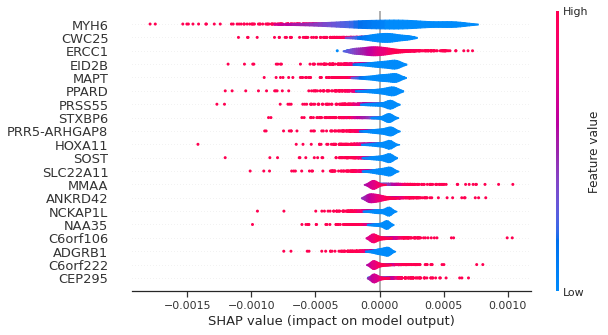

In [260]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.summary_plot(shap_values, data, plot_type='violin', max_display=display, plot_size=(9.2, 5), show=False)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Summary.png');

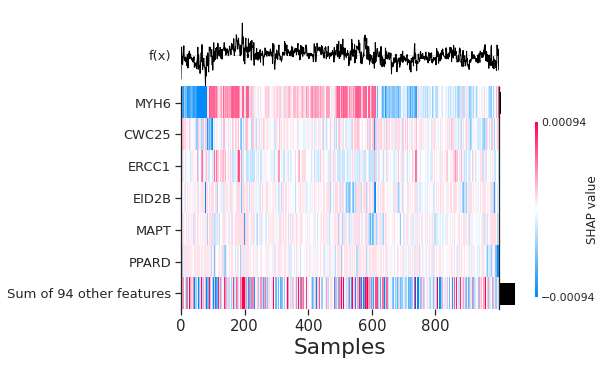

In [261]:
plt.figure(figsize=(10, 5))
shap.plots.heatmap(shap_values, max_display=7, show=False)  # 7 because problem with visualization and tight layout
plt.gca().set_xlabel('Samples')
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Heat.png');

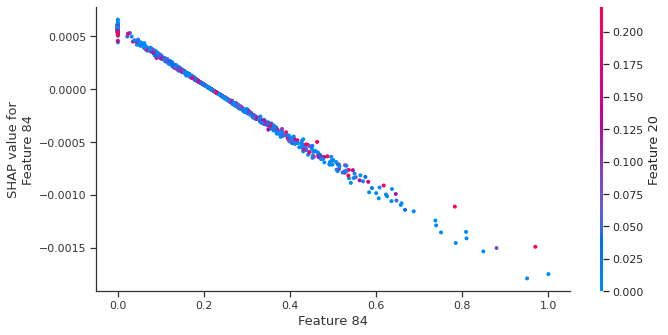

In [262]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.dependence_plot(np.argsort(np.abs(shap_values.values).mean(0))[::-1][0], shap_values.values, data, ax=ax, show=False)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Dep1.png');

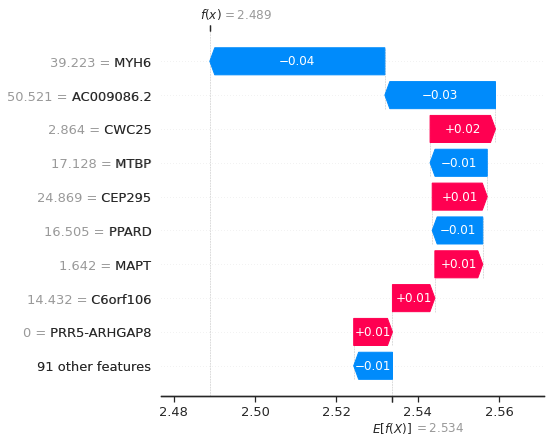

In [263]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.plots.waterfall(100*shap_values[0], show=False)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Waterfall1.png');

### Interactive

In [44]:
# # Kernel Explainer
# kexplainer = shap.KernelExplainer(model, shap.kmeans(data, 10), feature_names=feature_names, output_names=output_names)
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     kshap_values = kexplainer.shap_values(data, nsamples=100)

In [45]:
# shap.force_plot(kexplainer.expected_value, kshap_values[0, :], data[0, :], matplotlib=True, show=False)
# plt.savefig('./output_figures/' + dataset_name + '-Force.png', bbox_inches='tight');

In [46]:
# shap.initjs()
# shap.force_plot(kexplainer.expected_value, kshap_values, data)